In [1]:
import sys
import random
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from sumolib import checkBinary
from torch_geometric.data import Batch
import matplotlib.pyplot as plt
import pandas as pd
import os
import math
from utils import *
from Models import *
from Envs import *

if 'SUMO_HOME' in os.environ:
    print('SUMO_HOME found')
    sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))

sumoBinary = checkBinary('sumo')
roadNetwork = "./config/osm.sumocfg"
sumoCmd = [sumoBinary, "-c", roadNetwork, "--start", "--quit-on-end"]
# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

SUMO_HOME found
SUMO_HOME found
Using device: cuda


In [2]:
def train():
    env.reset()
    done = False
    step_num = 0
    accumulated_rewards = []
    for i_episode in range(100):
        step_num += 1
        done = env.sim_done()
        state = env.step()
        for i in range(200):
            state = env.refresh()
            accumulated_reward = 0
            routing_done = False
            while not routing_done:
                action_mask = env.get_action_mask()

                # shuffle_indices = torch.randperm(max_n_neighbors)
                shuffle_indices = torch.tensor([0, 1, 2, 3, 4, 5])
                action, use_policy = select_action(state, action_mask, shuffle_indices)

                if use_policy:
                    next_state, reward, routing_done = env.act(shuffle_indices[action.item()])
                else:
                    next_state, reward, routing_done = env.act(action.item())
                reward = torch.tensor([reward], device=device)
                accumulated_reward += reward.item()

                routing_done = routing_done

                if routing_done:
                    memory.push(state, action, None, reward, shuffle_indices)
                else:
                    memory.push(state, action, next_state, reward, shuffle_indices)

                # Move to the next state
                state = next_state

                optimize_model()
                if steps_done % 20 == 0:
                    target_net_state_dict = target_net.state_dict()
                    policy_net_state_dict = policy_net.state_dict()
                    for key in policy_net_state_dict:
                        target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
                    target_net.load_state_dict(target_net_state_dict)
            accumulated_rewards.append(accumulated_reward)
            if i == 190:
                print(f"Step: {step_num}, Iteration: {i}, Accumulated reward: {accumulated_reward}")
    return accumulated_rewards

In [3]:
BATCH_SIZE = 128
GAMMA = 0.95
EPS_START = 0.2
EPS_END = 0.001
EPS_DECAY = 5000
TAU = 0.05
LR = 0.001

Transition = namedtuple('Transition',
                        ('data', 'action', 'next_state', 'reward', 'shuffle_indices'))


def select_action(data, action_mask, shuffle_indices):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return torch.tensor([policy_net(data, shuffle_indices).max(1).indices.item()], device=device), True
    else:
        valid_size = len(torch.where(action_mask == 1)[0])
        return torch.randint(0, valid_size, (1,), device=device), False



def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = Batch.from_data_list([s for s in batch.next_state
                                                if s is not None])
    data_batch = Batch.from_data_list(batch.data)
    action_batch = torch.stack(batch.action)
    reward_batch = torch.concat(batch.reward)
    shuffle_indices_batch = torch.stack(batch.shuffle_indices)

    state_action_values = policy_net(data_batch, shuffle_indices_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [4]:
n_nodes = 55
env = RoutingGym(sumoCmd, 1100, n_nodes, max_n_neighbors=6)
max_n_neighbors = 6

policy_net = GDQN_Attention(n_nodes=n_nodes, max_n_neighbors=max_n_neighbors).to(device)
target_net = GDQN_Attention(n_nodes=n_nodes, max_n_neighbors=max_n_neighbors).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(1000000)
steps_done = 0
accumulated_rewards = train()

 Retrying in 1 seconds
***Starting server on port 37625 ***
Loading net-file from './config/osm.net.xml.gz' ... done (112ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.


/home/andyfu/Desktop/road_networks/Larger_Edinburgh/Envs.py:191: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.state, torch.tensor(reward).to(device), self.routing_done


Step: 1, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 2, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 3, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 4, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 5, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 6, Iteration: 190, Accumulated reward: 0.39411763846874237
Step: 7, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 8, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 9, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 10, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 11, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 12, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 13, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 14, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 15, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 16, Iteration: 190, Accumul

[Text(0.5, 0, 'Episode'),
 Text(0, 0.5, 'Accumulated reward'),
 Text(0.5, 1.0, 'Reward history of DQN')]

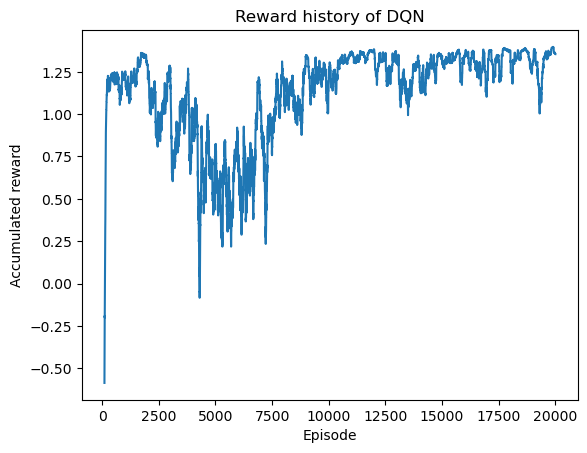

In [5]:
# save reward history
accumulated_rewards = pd.DataFrame(accumulated_rewards)
accumulated_rewards.to_csv('reward_history_gatten_iterate.csv', index=False)
# smooth the reward history
accumulated_rewards = accumulated_rewards.rolling(window=100).mean()
fig, ax = plt.subplots()
ax.plot(accumulated_rewards)
ax.set(xlabel='Episode', ylabel='Accumulated reward',
       title='Reward history of DQN')

In [7]:
def test():
    env.reset()
    accumulated_rewards = []
    done = False
    while not done:
        state = env.step()
        done = env.sim_done()
        accumulated_reward = 0
        routing_done = False
        while not routing_done:
            action_mask = env.get_action_mask()
            shuffle_indices = torch.tensor([0, 1, 2, 3, 4, 5])
            action, use_policy = select_action(state, action_mask, shuffle_indices)
            node_features, reward, routing_done = env.act(action.item())
            reward = torch.tensor([reward], device=device)
            accumulated_reward += reward.item()

            routing_done = routing_done

            if routing_done:
                next_state = None
            else:
                next_state = node_features

            # Move to the next state
            state = next_state
        accumulated_rewards.append(accumulated_reward)
    return accumulated_rewards

In [7]:
test_rewards = np.array(test())
# save the test rewards
np.save("test_rewards_gatten.npy", test_rewards)
print("Average test reward: ", np.mean(test_rewards))

Simulation ended at time: 500.00
Reason: TraCI requested termination.
Performance: 
 Duration: 3887.49s
 TraCI-Duration: 3859.14s
 Real time factor: 0.128618
 UPS: 3.254028
Vehicles: 
 Inserted: 55 (Loaded: 70)
 Running: 44
 Waiting: 0
Statistics (avg of 11):
 RouteLength: 2348.59
 Speed: 9.89
 Duration: 244.45
 WaitingTime: 5.91
 TimeLoss: 30.81
 DepartDelay: 0.41

 Retrying in 1 seconds
***Starting server on port 49389 ***
Loading net-file from './config/osm.net.xml.gz' ... done (106ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Average test reward:  0.9564405450339665


In [8]:
n_nodes = 55
env = RoutingGym(sumoCmd, 1100, n_nodes, max_n_neighbors=6)
max_n_neighbors = 6

policy_net = SAGE_GDQN_Attention(n_nodes=n_nodes, max_n_neighbors=max_n_neighbors).to(device)
target_net = SAGE_GDQN_Attention(n_nodes=n_nodes, max_n_neighbors=max_n_neighbors).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(1000000)
steps_done = 0
accumulated_rewards = train()

Simulation ended at time: 1101.00
Reason: TraCI requested termination.
Performance: 
 Duration: 30.17s
 TraCI-Duration: 29.12s
 Real time factor: 36.4993
 UPS: 1352.660368
Vehicles: 
 Inserted: 89
 Running: 30
 Waiting: 0
Statistics (avg of 59):
 RouteLength: 4182.20
 Speed: 9.57
 Duration: 445.32
 WaitingTime: 15.56
 TimeLoss: 61.37
 DepartDelay: 0.48

 Retrying in 1 seconds
***Starting server on port 43427 ***
Loading net-file from './config/osm.net.xml.gz' ... done (110ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Step: 1, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 2, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 3, Iteration: 190, Accumulated reward: 0.4833333268761635
Step: 4, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 5, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 6, Iteration: 190, Accumulated reward: 1.064285732805729
Step: 7, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 

[Text(0.5, 0, 'Episode'),
 Text(0, 0.5, 'Accumulated reward'),
 Text(0.5, 1.0, 'Reward history of DQN')]

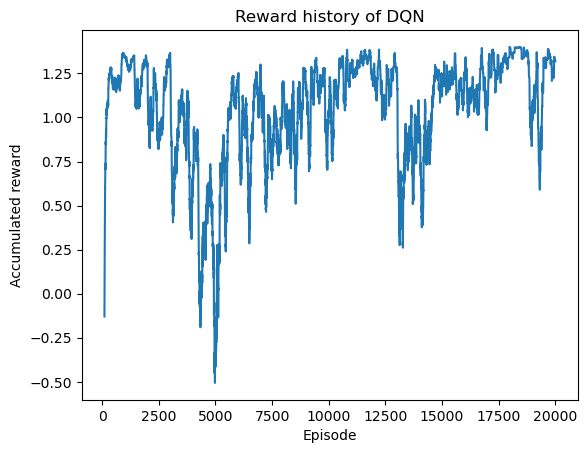

In [9]:
# save reward history
accumulated_rewards = pd.DataFrame(accumulated_rewards)
accumulated_rewards.to_csv('reward_history_sageatten_iterate.csv', index=False)
# smooth the reward history
accumulated_rewards = accumulated_rewards.rolling(window=100).mean()
fig, ax = plt.subplots()
ax.plot(accumulated_rewards)
ax.set(xlabel='Episode', ylabel='Accumulated reward',
       title='Reward history of DQN')

In [10]:
test_rewards = np.array(test())
# save the test rewards
np.save("test_rewards_sageatten.npy", test_rewards)
print("Average test reward: ", np.mean(test_rewards))

Simulation ended at time: 500.00
Reason: TraCI requested termination.
Performance: 
 Duration: 6789.20s
 TraCI-Duration: 6708.24s
 Real time factor: 0.0736464
 UPS: 1.863253
Vehicles: 
 Inserted: 55 (Loaded: 70)
 Running: 44
 Waiting: 0
Statistics (avg of 11):
 RouteLength: 2348.59
 Speed: 9.89
 Duration: 244.45
 WaitingTime: 5.91
 TimeLoss: 30.81
 DepartDelay: 0.41

 Retrying in 1 seconds
***Starting server on port 43047 ***
Loading net-file from './config/osm.net.xml.gz' ... done (150ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Average test reward:  1.1406369580862015


In [4]:
n_nodes = 55
env = RoutingGym(sumoCmd, 1100, n_nodes, max_n_neighbors=6)
max_n_neighbors = 6

policy_net = JK_SAGE_GDQN_Attention(n_nodes=n_nodes, max_n_neighbors=max_n_neighbors).to(device)
target_net = JK_SAGE_GDQN_Attention(n_nodes=n_nodes, max_n_neighbors=max_n_neighbors).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(1000000)
steps_done = 0
accumulated_rewards = train()

 Retrying in 1 seconds
***Starting server on port 39909 ***
Loading net-file from './config/osm.net.xml.gz' ... done (113ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.


/home/andyfu/Desktop/road_networks/Larger_Edinburgh/Envs.py:191: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.state, torch.tensor(reward).to(device), self.routing_done


Step: 1, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 2, Iteration: 190, Accumulated reward: 0.1499999761581421
Step: 3, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 4, Iteration: 190, Accumulated reward: -1.600000061094761
Step: 5, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 6, Iteration: 190, Accumulated reward: 0.8555555790662766
Step: 7, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 8, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 9, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 10, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 11, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 12, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 13, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 14, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 15, Iteration: 190, Accumulated reward: 1.4000000059604645
Step: 16, Iteration: 190, Accumula

[Text(0.5, 0, 'Episode'),
 Text(0, 0.5, 'Accumulated reward'),
 Text(0.5, 1.0, 'Reward history of DQN')]

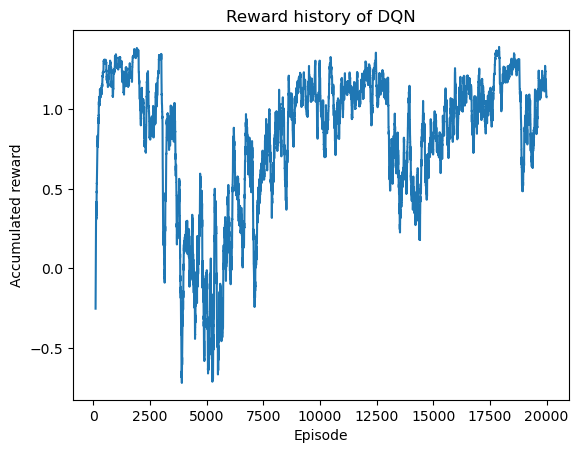

In [5]:
# save reward history
accumulated_rewards = pd.DataFrame(accumulated_rewards)
accumulated_rewards.to_csv('reward_history_jksageatten_iterate.csv', index=False)
# smooth the reward history
accumulated_rewards = accumulated_rewards.rolling(window=100).mean()
fig, ax = plt.subplots()
ax.plot(accumulated_rewards)
ax.set(xlabel='Episode', ylabel='Accumulated reward',
       title='Reward history of DQN')

In [8]:
test_rewards = np.array(test())
# save the test rewards
np.save("test_rewards_jksageatten.npy", test_rewards)
print("Average test reward: ", np.mean(test_rewards))

Simulation ended at time: 500.00
Reason: TraCI requested termination.
Performance: 
 Duration: 9473.10s
 TraCI-Duration: 9370.47s
 Real time factor: 0.052781
 UPS: 1.335360
Vehicles: 
 Inserted: 55 (Loaded: 70)
 Running: 44
 Waiting: 0
Statistics (avg of 11):
 RouteLength: 2348.59
 Speed: 9.89
 Duration: 244.45
 WaitingTime: 5.91
 TimeLoss: 30.81
 DepartDelay: 0.41

 Retrying in 1 seconds
***Starting server on port 56215 ***
Loading net-file from './config/osm.net.xml.gz' ... done (103ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
Average test reward:  1.0261227730635059


In [ ]:
# save the model
torch.save(policy_net.state_dict(), 'policy_net.pth')
torch.save(target_net.state_dict(), 'target_net.pth')